# NREL - HSDS Data Export

This notebook demonstrates data export from the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit and National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

Please consult the README file for setup instructions prior to running this notebook.


In [6]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import dateutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../bin')
# convenience functions
from functions import WTK_idx, NSRDB_idx, datetimeIndex

[WTK](#WIND-Toolkit-(WTK)) | [NSRDB](#National-Solar-Radiation-Database-(NSRDB))

## WIND Toolkit (WTK)
### Single Multivariate Timeseries

In [8]:
# open wtk-us.h5 "file" and list datasets
wtk = h5pyd.File("/nrel/wtk-us.h5")  
for dset_name in wtk:
    dset = wtk[dset_name]
    print(f"{dset_name} - {dset.shape}")

DIF - (61368, 1602, 2976)
DNI - (61368, 1602, 2976)
GHI - (61368, 1602, 2976)
coordinates - (1602, 2976)
datetime - (61368,)
inversemoninobukhovlength_2m - (61368, 1602, 2976)
precipitationrate_0m - (61368, 1602, 2976)
pressure_0m - (61368, 1602, 2976)
pressure_100m - (61368, 1602, 2976)
pressure_200m - (61368, 1602, 2976)
relativehumidity_2m - (61368, 1602, 2976)
status - (61368,)
temperature_100m - (61368, 1602, 2976)
temperature_10m - (61368, 1602, 2976)
temperature_120m - (61368, 1602, 2976)
temperature_140m - (61368, 1602, 2976)
temperature_160m - (61368, 1602, 2976)
temperature_200m - (61368, 1602, 2976)
temperature_2m - (61368, 1602, 2976)
temperature_40m - (61368, 1602, 2976)
temperature_60m - (61368, 1602, 2976)
temperature_80m - (61368, 1602, 2976)
winddirection_100m - (61368, 1602, 2976)
winddirection_10m - (61368, 1602, 2976)
winddirection_120m - (61368, 1602, 2976)
winddirection_140m - (61368, 1602, 2976)
winddirection_160m - (61368, 1602, 2976)
winddirection_200m - (61368

The following code fetches daily timeseries data for a given lat/lon for three variables.

In [9]:
LongsPeak_idx = WTK_idx(wtk, (40.2549, -105.6160))
LongsPeak_idx

(921, 1093)

In [10]:
%time df = pd.DataFrame({"temperature_100m": wtk['temperature_100m'][:, LongsPeak_idx[0], LongsPeak_idx[1]],\
                         "windspeed_100m": wtk['windspeed_100m'][:, LongsPeak_idx[0], LongsPeak_idx[1]],\
                         "pressure_100m": wtk['pressure_100m'][:, LongsPeak_idx[0], LongsPeak_idx[1]]},\
                         index=map(dateutil.parser.parse, wtk["datetime"][:]))
df.index.name = 'datetime'
df.head()

CPU times: user 1.98 s, sys: 13.9 ms, total: 2 s
Wall time: 2min 29s


,temperature_100m,windspeed_100m,pressure_100m
datetime,,,
2007-01-01 00:00:00,266.147339,9.109772,63688.468750
2007-01-01 01:00:00,266.312134,10.260323,63682.058594
2007-01-01 02:00:00,266.220581,11.548203,63661.000000
2007-01-01 03:00:00,266.174805,11.844231,63645.437500
2007-01-01 04:00:00,265.955078,12.570572,63644.519531


In [11]:
# save data to csv
df.to_csv('longspeak_wtk.csv')

### All Within Bounding Box

In [12]:
def indicesForBBox(wtk, lat_range, lon_range):
    xmin = None
    xmax = None
    ymin = None
    ymax = None
    for i in [0,1]:
        for j in [0,1]:
            yx = WTK_idx(wtk, (lat_range[i], lon_range[j]))
            if xmin is None or yx[1] < xmin:
                xmin = yx[1]
            if xmax is None or yx[1] > xmax:
                xmax = yx[1]
            if ymin is None or yx[0] < ymin:
                ymin = yx[0]
            if ymax is None or yx[0] > ymax:
                ymax = yx[0]
    return ([xmin, xmax], [ymin, ymax])

# This bounding box is the state of Colorado, more or less
(x_range,y_range) = indicesForBBox(wtk, [36.96744946416934, 41.02964338716638],
                                   [-109.05029296875, -102.0849609375])

print("x range for Colorado = (%d,%d)" % (x_range[0], x_range[1]))
print("y range for Colorado = (%d,%d)" % (y_range[0], y_range[1]))

x range for Colorado = (924,1241)
y range for Colorado = (729,982)


In [13]:
# Get every other windspeed measurement within this box for a given time step
dtdf = datetimeIndex(wtk)
dset = wtk['windspeed_100m']
timestep = dtdf.loc[dtdf.datetime == '2012-04-01 12:00:00'].index[0]
%time data = dset[timestep, y_range[0]:y_range[1]:2, x_range[0]:x_range[1]:2]  # :2 means every second point

CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 547 ms


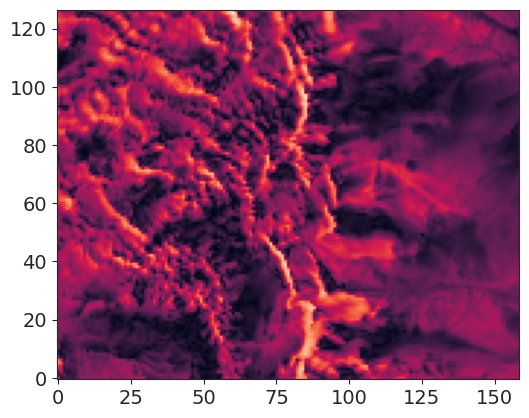

In [14]:
plt.imshow(data, origin="lower")

In [15]:
print( "There are ...")
print( "  %d points within this box a 2km resolution" % ((x_range[1] - x_range[0]) * (y_range[1] - y_range[0]),))
print( "  %d points within this box at 4km resolution" % ((x_range[1] - x_range[0]) / 2 * (y_range[1] - y_range[0]) / 2,))
print( "  %d points within this box at 8km resolution" % ((x_range[1] - x_range[0]) / 4 * (y_range[1] - y_range[0]) / 4,))
print( "  %d points within this box at 16km resolution" % ((x_range[1] - x_range[0]) / 8 * (y_range[1] - y_range[0]) / 8,))

There are ...
  80201 points within this box a 2km resolution
  20050 points within this box at 4km resolution
  5012 points within this box at 8km resolution
  1253 points within this box at 16km resolution


In [16]:
spacing = 8 # every 8th point is 16km resolution
cube = dset[::(24 * 30), y_range[0]:y_range[1]:spacing, x_range[0]:x_range[1]:spacing] # every 30 days

In [17]:
# Convert data cube to a datafame where each location is a column
ll_for_coords = wtk['coordinates'][y_range[0]:y_range[1]:spacing, x_range[0]:x_range[1]:spacing]
df = pd.DataFrame()
for i in range(len(ll_for_coords)):
    for j in range(len(ll_for_coords[i])):
        colname = "%.03f,%.03f" % (ll_for_coords[i][j][1], ll_for_coords[i][j][0])
        df[colname] = cube[:, i, j]

df.index = wtk["datetime"][::(24 * 30)]
df.index.name = 'datetime'
        
df.head()

/tmp/ipykernel_6162/139628529.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colname] = cube[:, i, j]
/tmp/ipykernel_6162/139628529.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colname] = cube[:, i, j]
/tmp/ipykernel_6162/139628529.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

,"-108.918,36.314","-108.738,36.337","-108.558,36.360","-108.377,36.383","-108.196,36.406","-108.016,36.428","-107.835,36.450","-107.654,36.471","-107.472,36.492","-107.291,36.513",...,"-104.031,41.443","-103.834,41.458","-103.637,41.472","-103.439,41.486","-103.242,41.500","-103.044,41.513","-102.846,41.526","-102.648,41.538","-102.450,41.551","-102.252,41.562"
datetime,,,,,,,,,,,,,,,,,,,,,
b'20070101000000',1.232948,1.629692,1.474045,2.407913,1.113922,1.477097,1.120026,1.962341,1.522873,1.815849,...,5.334633,5.923645,6.982635,8.450577,8.066040,7.095551,7.397690,7.837151,8.795433,9.939880
b'20070131000000',4.055908,1.318398,0.811790,7.196266,9.112823,8.435318,8.874786,8.508560,4.971466,8.020264,...,9.378342,9.118927,9.991760,10.074158,10.666222,8.908356,5.746635,5.627617,7.068085,7.889038
b'20070302000000',9.503464,7.907349,9.765923,8.896149,10.589920,11.215553,11.651970,11.789299,13.245033,14.325386,...,14.334541,14.014099,14.267403,13.580734,15.317238,13.931702,17.725151,12.323372,4.898224,6.878876
b'20070401000000',9.631645,5.987732,6.930756,7.416000,8.182014,8.984650,9.555344,11.316261,11.999878,11.658073,...,11.181984,9.933777,10.150459,9.353920,9.222694,11.053802,11.615341,11.389511,11.590927,13.138222
b'20070501000000',6.634727,7.165749,7.733391,7.300026,6.323433,4.367195,4.599136,5.560471,6.070129,4.953156,...,5.648979,5.734428,8.044678,8.673363,8.844261,9.183022,9.054840,10.046692,10.013123,10.696739


In [18]:
df.to_csv("colorado_wtk-wspd.csv")

In [19]:
wtk.close()

## National Solar Radiation Database (NSRDB)
### Single Multivariate Timeseries

In [21]:
nsrdb = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2017.h5")

for dset_name in nsrdb:
    dset = nsrdb[dset_name]
    print(f"{dset_name} - {dset.shape}")

air_temperature - (17520, 2018392)
alpha - (17520, 2018392)
aod - (17520, 2018392)
asymmetry - (17520, 2018392)
cld_opd_dcomp - (17520, 2018392)
cld_reff_dcomp - (17520, 2018392)
clearsky_dhi - (17520, 2018392)
clearsky_dni - (17520, 2018392)
clearsky_ghi - (17520, 2018392)
cloud_press_acha - (17520, 2018392)
cloud_type - (17520, 2018392)
coordinates - (2018392, 2)
dew_point - (17520, 2018392)
dhi - (17520, 2018392)
dni - (17520, 2018392)
fill_flag - (17520, 2018392)
ghi - (17520, 2018392)
meta - (2018392,)
ozone - (17520, 2018392)
relative_humidity - (17520, 2018392)
solar_zenith_angle - (17520, 2018392)
ssa - (17520, 2018392)
surface_albedo - (17520, 2018392)
surface_pressure - (17520, 2018392)
time_index - (17520,)
total_precipitable_water - (17520, 2018392)
wind_direction - (17520, 2018392)
wind_speed - (17520, 2018392)


In [22]:
LongsPeak_idx = NSRDB_idx(nsrdb, (40.2549, -105.6160))
LongsPeak_idx

152117

In [23]:
# function to unscale nsrdb timeseries
def unscale_dset(nsrdb, dset_name, idx):
    dset = nsrdb[dset_name]
    return dset[:, idx] / dset.attrs['psm_scale_factor']

In [24]:
%time df = pd.DataFrame({"air_temperature": unscale_dset(nsrdb, 'air_temperature', LongsPeak_idx),\
                         "wind_speed": unscale_dset(nsrdb, 'wind_speed', LongsPeak_idx),\
                         "ghi": unscale_dset(nsrdb, 'ghi', LongsPeak_idx),\
                         "dhi": unscale_dset(nsrdb, 'dhi', LongsPeak_idx),\
                         "dni": unscale_dset(nsrdb, 'dni', LongsPeak_idx)},\
                        index=nsrdb['time_index'][...].astype(str))
df.index.name = 'datetime'
df.head()

CPU times: user 20.3 ms, sys: 552 μs, total: 20.8 ms
Wall time: 5.88 s


,air_temperature,wind_speed,ghi,dhi,dni
datetime,,,,,
2017-01-01T00:00:00.000000000,-13.0,1.0,0.0,0.0,0.0
2017-01-01T00:30:00.000000000,-13.0,1.1,0.0,0.0,0.0
2017-01-01T01:00:00.000000000,-13.0,1.2,0.0,0.0,0.0
2017-01-01T01:30:00.000000000,-13.0,1.4,0.0,0.0,0.0
2017-01-01T02:00:00.000000000,-14.0,1.6,0.0,0.0,0.0


In [25]:
# save data to csv
df.to_csv('longspeak_nsrdb.csv')

### Variable for a geographic region (State)

In [26]:
def metaForState(nsrdb, state):
    meta = pd.DataFrame(nsrdb['meta'][...])
    state = meta.loc[meta['state'] == str.encode(state)] # Note .h5 saves strings as bit-strings
    return state

# Extract all of Colorado
CO_sites = metaForState(nsrdb, 'Colorado')

In [27]:
print( "There are ...")
print( "  {} points within CO at 4km resolution".format(len(CO_sites)))
print( "  {} points within CO at 8km resolution".format(len(CO_sites[::2])))
print( "  {} points within CO at 16km resolution".format(len(CO_sites[::4])))

There are ...
  17500 points within CO at 4km resolution
  8750 points within CO at 8km resolution
  4375 points within CO at 16km resolution


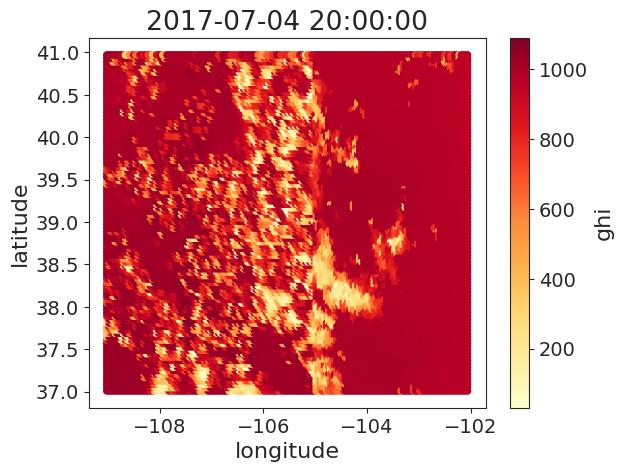

In [28]:
# Map GHI for July 4th
time_index = pd.to_datetime(nsrdb['time_index'][...].astype(str))
timestep = np.where(time_index == '2017-07-04 20:00:00')[0][0]
ghi = nsrdb['ghi'][timestep][CO_sites.index] / nsrdb['ghi'].attrs['psm_scale_factor']
df = CO_sites[['longitude', 'latitude']].copy()
df['ghi'] = ghi

df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [29]:
# Pull hourly ghi for every 4th site in CO:
df = pd.DataFrame()
for idx, row in CO_sites.iloc[::4].iterrows():
    lat_lon = '{:.2f}, {:.2f}'.format(*row[['latitude', 'longitude']].values)
    df[lat_lon] = unscale_dset(nsrdb, 'ghi', idx)[::2]

df.index = time_index[::2]
df.index.name = 'datetime'
df.head()

/tmp/ipykernel_6162/1604388886.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lat_lon] = unscale_dset(nsrdb, 'ghi', idx)[::2]
/tmp/ipykernel_6162/1604388886.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lat_lon] = unscale_dset(nsrdb, 'ghi', idx)[::2]
/tmp/ipykernel_6162/1604388886.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

,"37.01, -109.02","37.01, -108.86","37.01, -108.70","37.01, -108.54","37.01, -108.38","37.01, -108.22","37.01, -108.06","37.01, -107.90","37.01, -107.74","37.01, -107.58",...,"40.61, -102.06","40.41, -102.06","38.53, -102.06","37.17, -102.06","39.69, -102.06","39.13, -102.06","38.49, -102.06","37.49, -102.06","38.37, -102.06","38.73, -102.06"
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Save to .csv
df.to_csv("colorado_nsrdb-ghi.csv")

In [31]:
nsrdb.close()